In [1]:
import random

import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
from sklearn.manifold import TSNE

Датасет для классификации эмоцианольной окраски текста, но мы будем использовать его для кластеризации.  
Ссылка на датасет: https://www.kaggle.com/pashupatigupta/emotion-detection-from-text

In [2]:
RANDOM_STATE = 17
random.seed = RANDOM_STATE

In [3]:
data = pd.read_csv('tweet_emotions.csv')
data.drop('tweet_id', inplace=True, axis=1)
data.drop_duplicates(inplace=True)
data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [4]:
data.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [5]:
NUM_CLUSTERS = len(data.sentiment.unique())

<AxesSubplot:>

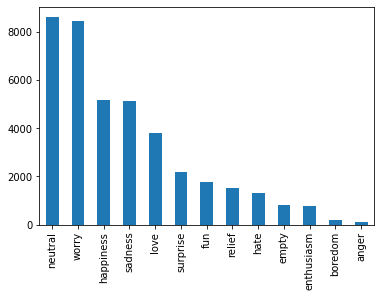

In [6]:
data.sentiment.value_counts().plot(kind='bar')

Данные не сбалансированы по классам, но это не имеет особого значения для нашей задачи. В будущем мелкие классы можно будет объеденить в один.

## Базовый препроцессинг

### Удаление знаков препинания

In [7]:
is_punct = lambda i: not(i.isalpha() or i.isdigit() or i.isspace())
data.content = data.content.apply(lambda text: ''.join( [' ' if is_punct(i) else i for i in text ] ))

In [8]:
data.head()

,sentiment,content
0,empty,tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh waitin o...
2,sadness,Funeral ceremony gloomy friday
3,enthusiasm,wants to hang out with friends SOON
4,neutral,dannycastillo We want to trade with someone w...


### Создание словаря и кодирование

Будем кодировать с помощью TF IDF, так как этот алгоритм учитывает не только частоту слова в строке, но и во всём корпусе.

Количество фич - 47651, это довольно большое число, поэтому ограничу 10000.

In [9]:
vectorizer = TfidfVectorizer(max_features=10000)
tfidf = vectorizer.fit_transform(data.content)
tfidf.shape

(39909, 10000)

### Визуализация 

Для скорости работы вместо 39909 данных возьмём случайных 5000.

In [10]:
random_indexes = random.sample(range(len(data)), 5000)
random_tfidf = tfidf[random_indexes]
random_sentiment = data.iloc[random_indexes].sentiment

In [11]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)

In [12]:
X_tsne = tsne.fit_transform(random_tfidf)

In [13]:
def plot(x, hue):
    x_min, x_max = x.min(0), x.max(0)
    X_norm = (x-x_min) / (x_max-x_min)
    
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=[x for x, y in X_norm], y=[y for x, y in X_norm], hue=hue)

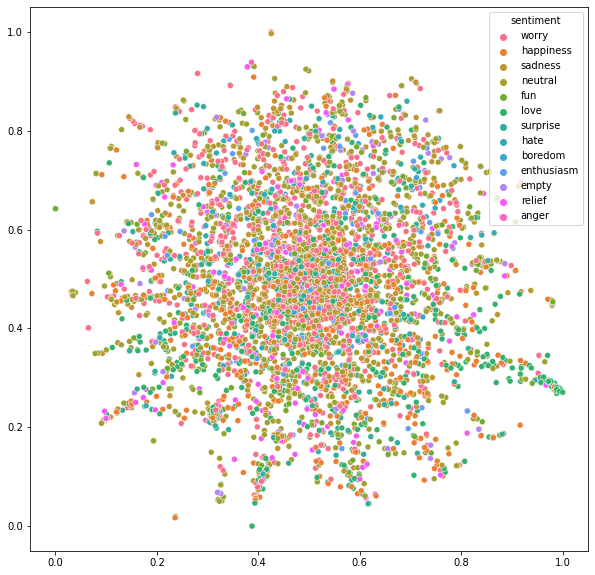

In [14]:
plot(X_tsne, random_sentiment)

На графике видно, что тяжело выделить отдельные кластеры, возможно, это последствие сжатия размерности.

## Кластеризация 

In [15]:
def get_metrics(y_true, y_pred, name='table'):
    homo, comp, v_measure = homogeneity_completeness_v_measure(y_true, y_pred)
    return pd.DataFrame({'homogeneity': homo, 'completeness': comp, 'v_measure': v_measure}, index=[name])

### K-means

In [16]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(random_tfidf)
labels

array([ 1,  1,  1, ...,  4, 11,  1])

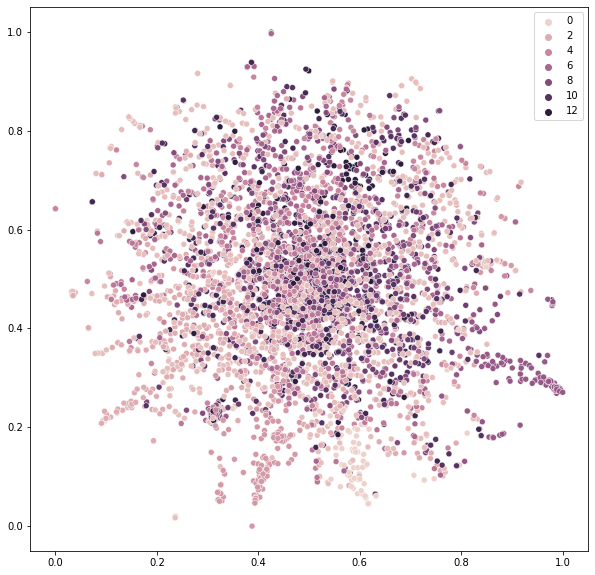

In [17]:
plot(X_tsne, labels)

In [18]:
k_means_metrics = get_metrics(random_sentiment, labels, 'k_means')
k_means_metrics

,homogeneity,completeness,v_measure
k_means,0.028,0.026209,0.027075


### Агломеративная кластеризация

In [19]:
optics = AgglomerativeClustering(n_clusters=NUM_CLUSTERS)
labels = optics.fit_predict(random_tfidf.toarray())
labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

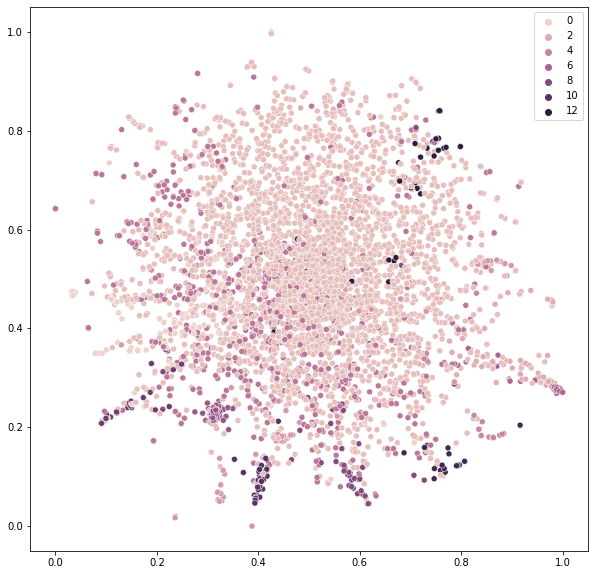

In [20]:
plot(X_tsne, labels)

In [21]:
agglomerative_metrics = get_metrics(random_sentiment, labels, 'agglomerative')
agglomerative_metrics

,homogeneity,completeness,v_measure
agglomerative,0.01895,0.038394,0.025376


## Продвинутый препроцессинг

### Лематизация

In [22]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\masht\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masht\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
lemmatizer = WordNetLemmatizer()
data.content = data.content.apply(lambda text: ' '.join( [lemmatizer.lemmatize(i) for i in text.split()] ))
data.head()

,sentiment,content
0,empty,tiffanylue i know i wa listenin to bad habit e...
1,sadness,Layin n bed with a headache ughhhh waitin on y...
2,sadness,Funeral ceremony gloomy friday
3,enthusiasm,want to hang out with friend SOON
4,neutral,dannycastillo We want to trade with someone wh...


### Создание словаря и кодирование

Убираем стандартные стоп слова и берём только те слова, частота встречаемости которыx находится в промежутке от 0.01% до 90%.

In [24]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=0.0001)
tfidf = vectorizer.fit_transform(data.content)
tfidf.shape

(39909, 6797)

In [26]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
random_tfidf = tfidf[random_indexes]
random_sentiment = data.iloc[random_indexes].sentiment
X_tsne = tsne.fit_transform(random_tfidf)

### Визуализация 

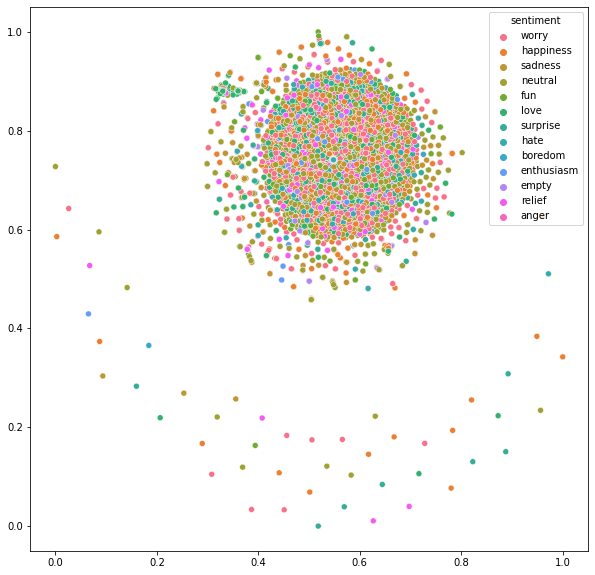

In [27]:
plot(X_tsne, random_sentiment)

На графике видно, что какие-то тексты сильно отличаются.

## Кластеризация 

### K-means

In [28]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(random_tfidf)
labels

array([ 8,  0,  5, ..., 12,  9,  1])

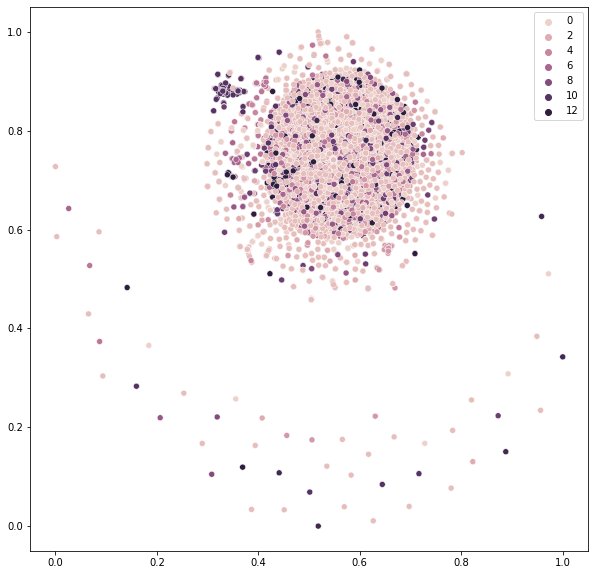

In [29]:
plot(X_tsne, labels)

In [30]:
k_means2_metrics = get_metrics(random_sentiment, labels, 'k_means2')
k_means2_metrics

,homogeneity,completeness,v_measure
k_means2,0.037082,0.043637,0.040093


### Агломеративная кластеризация

In [31]:
optics = AgglomerativeClustering(n_clusters=NUM_CLUSTERS)
labels = optics.fit_predict(random_tfidf.toarray())
labels

array([ 1,  1,  1, ...,  4, 10,  1], dtype=int64)

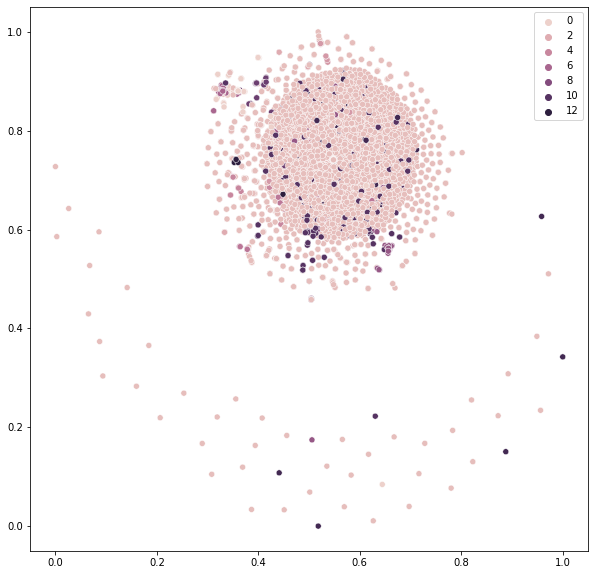

In [32]:
plot(X_tsne, labels)

In [33]:
agglomerative2_metrics = get_metrics(random_sentiment, labels, 'agglomerative2')
agglomerative2_metrics

,homogeneity,completeness,v_measure
agglomerative2,0.017441,0.059867,0.027013


### Результата

In [34]:
pd.concat([k_means_metrics, k_means2_metrics, agglomerative_metrics, agglomerative2_metrics])

,homogeneity,completeness,v_measure
k_means,0.028000,0.026209,0.027075
k_means2,0.037082,0.043637,0.040093
agglomerative,0.018950,0.038394,0.025376
agglomerative2,0.017441,0.059867,0.027013


Продвинутая предоработка немного улучшила результаты кластеризации.  
Лучшие результаты показал k_means с продвинутой предобработкой.  
Агломеративная кластеризация просто в один класс всё запихнула.